## Data Exploration

In [160]:
import pandas as pd
import numpy as np

# for string manipulation
import ast

# plotting
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

# custom functions
from util_functions import *

In [161]:
# import data 

# # These are the original patterns data files 
# four_star = pd.read_csv('data/patterns_4star.csv')
# five_star_clothing = pd.read_csv('data/patterns_5star_is_clothing.csv')
# five_star_not_clothing = pd.read_csv('data/patterns_5star_not_clothing.csv')

# this created from preliminarily cleaning and consolidating the above files
df = pd.read_csv('data/patterns_cleaned.csv', low_memory=False)

In [8]:
four_star.shape, five_star_clothing.shape, five_star_not_clothing.shape, df.shape

((79030, 24), (24583, 24), (85911, 24), (132843, 24))

A look at the data types

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188158 entries, 0 to 189523
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   pattern_id               188158 non-null  object 
 1   name                     188158 non-null  object 
 2   name_permalink           188158 non-null  object 
 3   favorites_count          188158 non-null  int64  
 4   projects_count           188158 non-null  int64  
 5   difficulty_average       188158 non-null  float64
 6   difficulty_count         182439 non-null  float64
 7   rating_average           188158 non-null  float64
 8   queued_projects_count    188158 non-null  int64  
 9   rating_count             188156 non-null  float64
 10  pattern_type_names       188154 non-null  object 
 11  pattern_type_clothing    188154 non-null  object 
 12  photos_url               188158 non-null  object 
 13  pattern_needle_sizes     188158 non-null  object 
 14  patt

#### Percentage of missing values

In [47]:
df.isnull().sum()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df['percent_missing'].sort_values(ascending=False)

yardage_max                31.907590
yardage                    13.911158
gauge                      10.008807
gauge_divisor               5.244537
yarn_weight_description     1.639529
difficulty_count            0.975588
free                        0.002258
downloadable                0.001506
rating_count                0.001506
pattern_type_names          0.000753
pattern_type_clothing       0.000753
photos_url                  0.000000
categories                  0.000000
pattern_needle_sizes        0.000000
pattern_attributes          0.000000
queued_projects_count       0.000000
rating_average              0.000000
generally_available         0.000000
difficulty_average          0.000000
projects_count              0.000000
favorites_count             0.000000
name_permalink              0.000000
name                        0.000000
pattern_id                  0.000000
Name: percent_missing, dtype: float64

### From Ravelry Search page:

#### Patterns
For content based filtering, we look at the features that make up particular patterns and make recommendations based only on the similarites of these to other patterns. 

There were too patterns to download - or rather it didn't make sense to download them all.  To narrow down the search, I first looked at some metrics displayed on the Ravelry website.

In [11]:
# From Ravelry.com - in numbers:
knitting_patterns = 665638
crochet = 435382
machine_knitting = 4008
loom_knitting = 4141
all_patterns = 1099169 # this includes crochet, machine and loom knitting as well 
knitting_rated_unrated = 469537

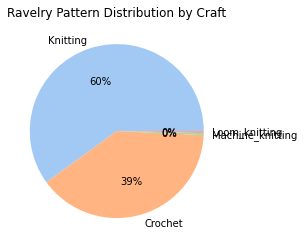

In [21]:
# Plot by craft
data = [knitting_patterns, crochet, machine_knitting, loom_knitting]
labels = ['Knitting', 'Crochet', 'Machine_knitting', 'Loom_knitting']

colors = sns.color_palette('pastel')[0:5]
title='Ravelry Pattern Distribution by Craft'

plt.pie(data, labels = labels,  colors= colors, autopct='%.0f%%')
plt.title('Ravelry Pattern Distribution by Craft')
plt.show()

For this project, we will only be looking at knitting specific patterns (666,612 in total).  Lets look at how many of these were rated.  This is open to anyone uploading patterns or projects to the website.  It's difficult to recommend patterns that haven't been tested:

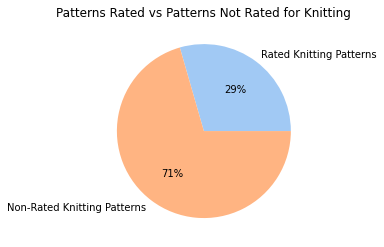

In [20]:
# Plot knitting by rated/ unrated
data = [knitting_patterns-knitting_rated_unrated, knitting_rated_unrated]
labels = ['Rated Knitting Patterns', 'Non-Rated Knitting Patterns']

plt.pie(data, labels = labels,  colors= colors, autopct='%.0f%%')
plt.title('Patterns Rated vs Patterns Not Rated for Knitting')
plt.show()

The assumption I made is that patterns will have at least one rating to be recommended, to narrow the scope, lets look at only the rated patterns: 

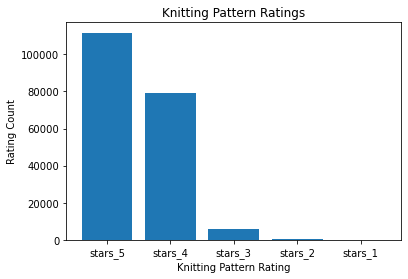

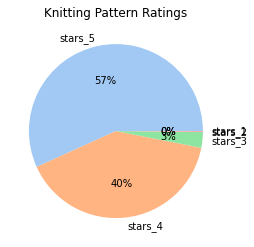

In [33]:
# Plot knitting patterns by rating (of those that were rated)
stars_5 = 111568
stars_4 = 78932
stars_3 = 5724
stars_2 = 321
stars_1 = 13

data = [stars_5, stars_4, stars_3, stars_2, stars_1 ]
labels = ['stars_5', 'stars_4', 'stars_3', 'stars_2','stars_1']

plt.bar(labels,data, label= 'Example one')
# plt.legend()
plt.title('Knitting Pattern Ratings')
plt.xlabel('Knitting Pattern Rating')
plt.ylabel('Rating Count')
plt.show()

plt.pie(data, labels = labels,  colors= colors, autopct='%.0f%%')
plt.title('Knitting Pattern Ratings')
plt.show()

The majority of the rated patterns are averaging a rating of 4 or 5 so we will limit the our recommendations to these 188158 patterns. (plotted both ways for better visual)

### Users
For collaborative filtering we look at the behavours between patterns and users. This is usually done by ratings. For this project, since there were so few ratings (and of the ratings that were given, there wasn't a large distribution: mostly 4's and 5's). I took the number of completed projects for an implicit rating (like on Netflix; if you watched a movie, it will recommend other movies like it even if you haven't rated it.)

Since there is a 100,000 limit for any api call from Ravelry, and a page size limit of 100 - 500 per call. I had to narrow down the scope. 

In [40]:
# The numbers:
projects = 18113264
users = 10247493

We want the most active users in order to fill in the utility matrix (the more sparse the user/ project matrix the more performance degrades).  One assumption is that users with avatars would be the most active.

In [44]:
users_with_avatar = 712601
print(f'{(users_with_avatar/users)*100:.2f}% of users have avatars.')

6.95% of users have avatars.


Another direction to look at this problem, is by looking at the patterns with a threshold of minimum projects made, then use those projects to call for users. This was the approach I used in the end. The plots can be seen after the next section. 

## Pattern Details
Look at each feature.
### Binary Features:
#### Free
May not tell much about the construction of the pattern, but does speak to the availability, and perhaps a little about the designer. 

In [50]:
df.free.unique()

array([True, False, nan], dtype=object)

In [56]:
df.free.isna().sum()

3

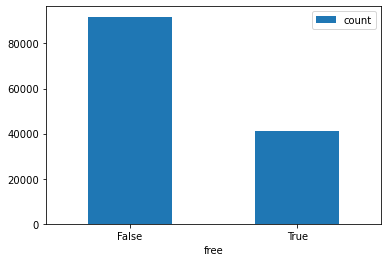

In [73]:
x = df[['free', 'name']].groupby('free', as_index = False).count()
x.rename(columns={"name": "count"}, inplace=True)
ax = x.plot.bar(x='free', y='count', rot=0)

### Downloadable
Like free, this may not tell much about the construction of the pattern, but does speak to the availability, if included, this will need to be down weighted.  If it's not downloadable, the pattern will be found in books generally. This is likely correlated with free. 

In [76]:
df.downloadable.isna().sum()

2

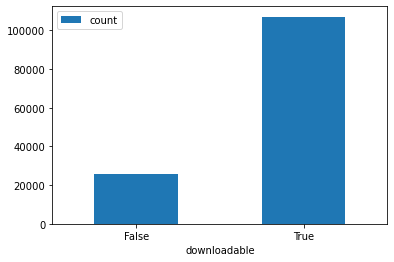

In [77]:
x = df[['downloadable', 'name']].groupby('downloadable', as_index = False).count()
x.rename(columns={"name": "count"}, inplace=True)
ax = x.plot.bar(x='downloadable', y='count', rot=0)

### pattern_type_clothing
This will tell us if the pattern is clothing or not - in hindsight this may not be useful as we have a number of other metrics to determine this (like categories)

In [80]:
df.pattern_type_clothing.isna().sum()

1

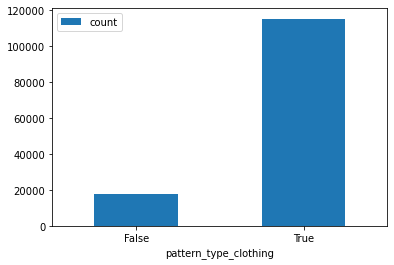

In [82]:
x = df[['pattern_type_clothing', 'name']].groupby('pattern_type_clothing', as_index = False).count()
x.rename(columns={"name": "count"}, inplace=True)
ax = x.plot.bar(x='pattern_type_clothing', y='count', rot=0)

In [78]:
df.columns
triple bar - favourits, project, queue, rating
difficulty distribution

word cloud
'pattern_type_names','pattern_attributes', categories

Index([ 'favorites_count',
       'projects_count', 'difficulty_average', 'difficulty_count',
       'rating_average', 'queued_projects_count', 'rating_count',
       'pattern_type_names',  
       'pattern_needle_sizes', 'pattern_attributes', 'yardage_max', 'yardage',
       'generally_available', 'gauge', 'gauge_divisor', 
       'categories', 'yarn_weight_description'],
      dtype='object')


month and year

individually plot 'yarn_weight_description','gauge', 'gauge_divisor, 'yardage_max', 'yardage' (move some functions into utils to help with this ! )
'pattern_needle_sizes'

also compare needle sizes with yarn weight

Index(['pattern_id', 'name', 'name_permalink', 'favorites_count',
       'projects_count', 'difficulty_average', 'difficulty_count',
       'rating_average', 'queued_projects_count', 'rating_count',
       'pattern_type_names', 'pattern_type_clothing', 'photos_url',
       'pattern_needle_sizes', 'pattern_attributes', 'yardage_max', 'yardage',
       'generally_available', 'gauge', 'gauge_divisor', 'free', 'downloadable',
       'categories', 'yarn_weight_description'],
      dtype='object')

In [83]:
# WORD CLOUD PATTERN TYPE NAME, CATEGORY, ATTRIBUTES, 

In [3]:
# df = pd.read_csv('data/patterns_cleaned.csv', low_memory=False)
# def to_sentence(x):
#     sentence = ' '.join(x)
#     sentence =  sentence.replace('-', '')
#     return sentence

# def filter_words(x):
#     list_attributes_to_keep = [ 'intarsia','lace','icord','felted','fair-isle','eyelets', 'entrelac','duplicate-stitch','doll-size', 'buttoned',
#                            'asymmetric','beads','bobble-or-popcorn','brioche-tuck', 'cables','ribbed','amigurumi','bias','double-knit',
#                             'shortrows', 'slippedstitches', 'stripes','thrums','short-rows', 'zipper']
#     new_words = list(filter(lambda w: w in list_attributes_to_keep, x))
#     return new_words

# def filter_attributes(df):   
#     try:
#         df['pattern_attributes'] = df['pattern_attributes'].apply(lambda x: ast.literal_eval(x))
#     except:
#         print("something went wrong with removing extra string from pattern attributes")
# #     df['pattern_attributes'] = df['pattern_attributes'].apply(lambda x: filter_words(x))
#     df['pattern_attributes'] = df['pattern_attributes'].apply(lambda x: to_sentence(x))
#     return df

# def get_corpus(df):
#     df = filter_attributes(df)
#     corpus = df['pattern_attributes'].tolist()
#     return corpus 

In [4]:
attributes = get_corpus(df)

In [17]:
attributes[0]

'unisex teen adult fitted reversible ribbed elastic buttoned buttonholes onepiece shortrows writtenpattern workedflat negativeease textured backfastening seamless'

In [16]:
text = attributes[0]
wordcloud = WordCloud().generate(text)

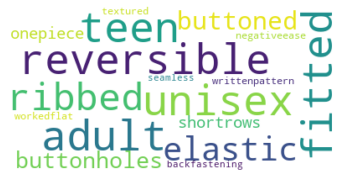

In [10]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Save the image in the img folder:
wordcloud.to_file("img/first_review.png")

In [18]:
text = " ".join(attribute for attribute in attributes)
print ("There are {} words in the combination of all attributes.".format(len(text)))

There are 11265285 words in the combination of all review.


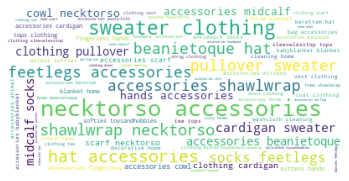

In [67]:
stopwords = set(STOPWORDS)
stopwords.update(["", "now", "wine", "flavor", "flavors"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
wine_mask = np.array(Image.open("img/wine_mask.png"))
wine_mask

In [ ]:
** use paired down subset and RECLOUD

#### Yardage
This refers to how many yards of yarn knitting up a pattern will require.  If yardage max column is filled, then a range has been given. This is especially important if there is a range of sizes specified for the pattern. (i.e. s, m, l, or baby, toddler, child, adult)

In [21]:
# PLOT AVG YARDAGE AND PATTERN TYPE DOUBLE BAR
# PATTERN TYPE DISTRIBUTION
df.yardage

Index(['pattern_id', 'name', 'name_permalink', 'favorites_count',
       'projects_count', 'difficulty_average', 'difficulty_count',
       'rating_average', 'queued_projects_count', 'rating_count',
       'pattern_type_names', 'pattern_type_clothing', 'photos_url',
       'pattern_needle_sizes', 'pattern_attributes', 'yardage_max', 'yardage',
       'generally_available', 'gauge', 'gauge_divisor', 'free', 'downloadable',
       'categories', 'yarn_weight_description'],
      dtype='object')

max yardage: 15748.0
average yardage: 551.41
median yardage: 400.00


(0.0, 3000.0)

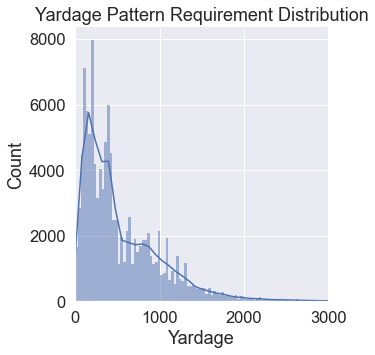

In [34]:
sns.set(font_scale=1.5)

print(f'max yardage: {max(df.yardage)}')
print(f'average yardage: {df.yardage.mean():.2f}')
print(f'median yardage: {df.yardage.median():.2f}')

p = sns.displot(x=df.yardage, bins=500, kde=True).set(title='Yardage Pattern Requirement Distribution');
p.set( xlabel = "Yardage");
plt.xlim(0, 3000)


### Pattern Type Name
A pattern type categorization.

max yardage: 15748.0
average yardage: 551.41
median yardage: 400.00


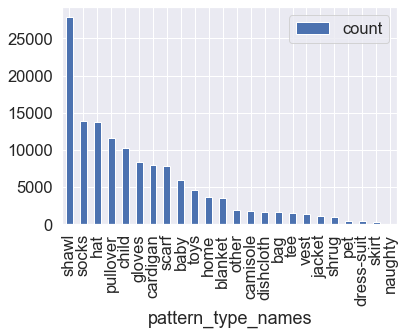

In [45]:
x = df[['pattern_type_names', 'name']].groupby('pattern_type_names', as_index = False).count().sort_values('name', ascending =False)
x.rename(columns={"name": "count"}, inplace=True)
ax = x.plot.bar(x='pattern_type_names', y='count', rot=90)



### Category
A sub-category of pattern type.  A number of these are a cross over of pattern_type names.

In [55]:
df.categories

0                   ['headband', 'headwear', 'accessories']
1         ['mid-calf', 'socks', 'feet-legs', 'accessories']
2         ['mid-calf', 'socks', 'feet-legs', 'accessories']
3                    ['beanie-toque', 'hat', 'accessories']
4         ['mid-calf', 'socks', 'feet-legs', 'accessories']
                                ...                        
132838                    ['washcloth', 'cleaning', 'home']
132839          ['shawl-wrap', 'neck-torso', 'accessories']
132840               ['scarf', 'neck-torso', 'accessories']
132841               ['scarf', 'neck-torso', 'accessories']
132842          ['shawl-wrap', 'neck-torso', 'accessories']
Name: categories, Length: 132843, dtype: object

In [72]:
# Convert to corpus to visualize
df['all_categories'] = df['categories'].apply(lambda x: ast.literal_eval(x))
df['all_categories'] = df['all_categories'].apply(lambda x: to_sentence(x))
corpus = df['all_categories'].tolist()

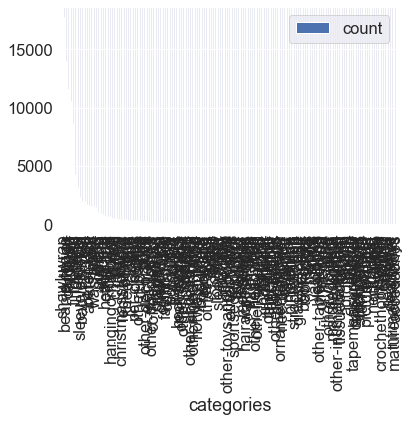

In [162]:
# df = parse_out_single_category(df)

# x = df[['categories', 'name']].groupby('categories', as_index = False).count().sort_values('name', ascending =False)
# x.rename(columns={"name": "count"}, inplace=True)
# ax = x.plot.bar(x='categories', y='count', rot=90)

In [73]:
text = " ".join(review for review in corpus)
print ("There are {} words in the combination of all attributes.".format(len(text)))

# text = " ".join(desc for desc in corpus)
# print ("There are {} words in the combination of all categories.".format(len(text)))
# text

There are 3657823 words in the combination of all attributes.


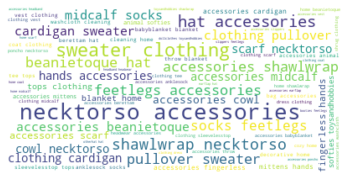

In [74]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [79]:
df = pd.read_csv('data/patterns_cleaned.csv', low_memory=False)
df = parse_out_single_category(df)


In [82]:
df.categories

0             headband
1             mid-calf
2             mid-calf
3         beanie-toque
4             mid-calf
              ...     
132838       washcloth
132839      shawl-wrap
132840           scarf
132841           scarf
132842      shawl-wrap
Name: categories, Length: 132843, dtype: object

In [76]:
corpus = df.categories.to_list

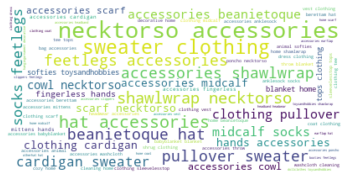

In [77]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Dates
I  anticipate that there would some seasonality component to pattern types.  I imagine more holiday and quick gift items like simple hats and mitten patterns would tend to be released towards the end of the year. More summery patterns like lace tees released (in the northern hemisphere) from march to august and layering clothing patterns towards the fall. 

There are some fashion trends that could be represented by the year released as well. 

In [ ]:
# PLOT PATTERN TYPE WITH MONTH ********************************************

In [84]:
df = split_date_released(df)

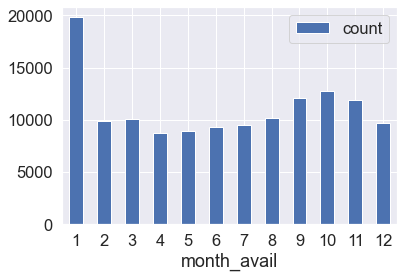

In [95]:
x = df[['month_avail', 'name']].groupby('month_avail', as_index = False).count()#.sort_values('name', ascending =False)
x.rename(columns={"name": "count"}, inplace=True)
ax = x.plot.bar(x='month_avail', y='count', rot=0)

average yardage: 551.41
median yardage: 400.00


(1990.0, 2021.0)

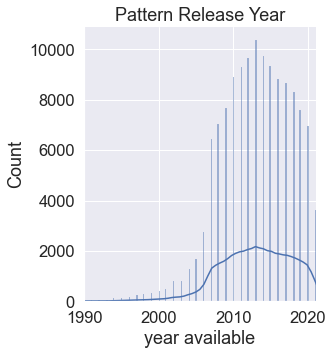

In [157]:
# x = df[['year_avail', 'name']].groupby('year_avail', as_index = False).count()#.sort_values('name', ascending =False)
# x.rename(columns={"name": "count"}, inplace=True)
# ax = x.plot.bar(x='year_avail', y='count', rot=90)

print(f'average yardage: {df.yardage.mean():.2f}')
print(f'median yardage: {df.yardage.median():.2f}')

p = sns.displot(x=df.year_avail, bins=500, kde=True).set(title='Pattern Release Year');
p.set( xlabel = "year available");
plt.xlim(1990, 2021)

The popularity boom for knitting around 2010 is shown above.  

### Favourites 
Patterns with high counts are explored further in 2.1 simple recommender.

max favourites: 74715.00
median favourites: 475.00
mean favourites: 1062.05


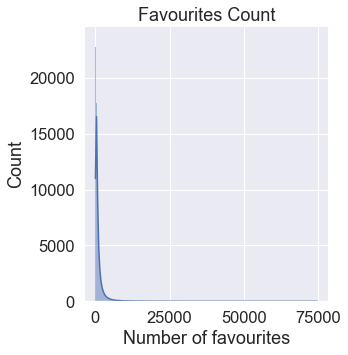

In [99]:
print(f'max favourites: {df.favorites_count.max():.2f}')
print(f'median favourites: {df.favorites_count.median():.2f}')
print(f'mean favourites: {df.favorites_count.mean():.2f}')

p = sns.displot(x=df.favorites_count, bins=500, kde=True).set(title='Favourites Count');
p.set( xlabel = "Number of favourites");
# plt.xlim(1990, 2021)

### Projects Count
Patterns with high counts are explored further in 2.1 simple recommender.

max projects: 35028.00
median projects: 29.00
mean projects: 98.10


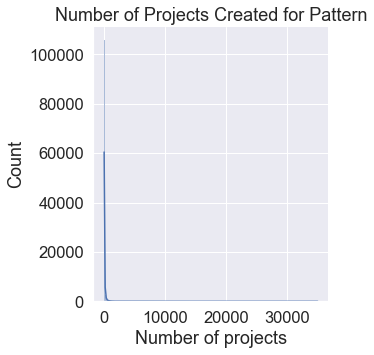

In [100]:
print(f'max projects: {df.projects_count.max():.2f}')
print(f'median projects: {df.projects_count.median():.2f}')
print(f'mean projects: {df.projects_count.mean():.2f}')

p = sns.displot(x=df.projects_count, bins=500, kde=True).set(title='Number of Projects Created for Pattern');
p.set( xlabel = "Number of projects");
# plt.xlim(1990, 2021)

(0.0, 100.0)

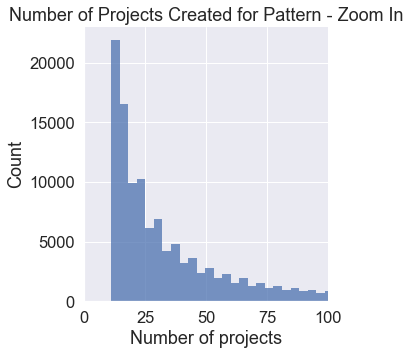

In [116]:
p = sns.displot(x=df.projects_count , bins=10000, kde=False).set(title='Number of Projects Created for Pattern - Zoom In');
p.set( xlabel = "Number of projects");
plt.xlim(0, 100)

### Pattern Difficulty
This could be described by either lack of solid instructions, or techiques used and skills required. This is rated by the users.

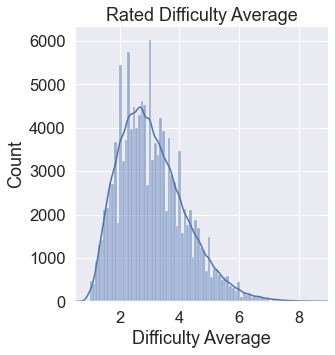

In [125]:
p = sns.displot(x=df.difficulty_average , bins=100, kde=True).set(title='Rated Difficulty Average');
p.set( xlabel = "Difficulty Average");

# there are some rated 0 - will need to evaluat those and potentially impute with middle metric
plt.xlim(0.5, 9);

### needle sizes
Needle sizes *************correlated with time take project, yard weight and fabric density - project type??


In [127]:
df.columns
df.pattern_needle_sizes

0         [{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...
1         [{'id': 21, 'us': '1½', 'metric': 2.5, 'us_ste...
2                                                        []
3         [{'id': 4, 'us': '4 ', 'metric': 3.5, 'us_stee...
4         [{'id': 21, 'us': '1½', 'metric': 2.5, 'us_ste...
                                ...                        
132838    [{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...
132839    [{'id': 5, 'us': '5 ', 'metric': 3.75, 'us_ste...
132840    [{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...
132841    [{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...
132842    [{'id': 4, 'us': '4 ', 'metric': 3.5, 'us_stee...
Name: pattern_needle_sizes, Length: 132843, dtype: object

Pull out the max needle sizes for knitting (knitting projects can have crochet borders or elements so hooks can be listed under patterns as well.  The main portion of the project will generally be done in the largest size. Smaller sizes are used for ribbed edging.

In [128]:
df = get_needle_size(df)

In [130]:
# df.columns

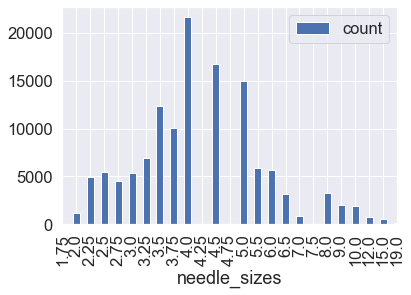

In [141]:
x = df[['needle_sizes', 'name']].groupby('needle_sizes', as_index = False).count()#.sort_values('name', ascending =False)
x.rename(columns={"name": "count"}, inplace=True)
ax = x.plot.bar(x='needle_sizes', y='count', rot=90)
plt.xlim(4, 28);

### Gauge 
Gauge is a measure of knitting speed, fabric density when in combination of uarn weight and measured in stitches per inch or stitches per 4 inches. If the yarn weight is l**********

In [142]:
df.columns

Index(['pattern_id', 'name', 'name_permalink', 'favorites_count',
       'projects_count', 'difficulty_average', 'difficulty_count',
       'rating_average', 'queued_projects_count', 'rating_count',
       'pattern_type_names', 'pattern_type_clothing', 'photos_url',
       'pattern_needle_sizes', 'pattern_attributes', 'yardage_max', 'yardage',
       'generally_available', 'gauge', 'gauge_divisor', 'free', 'downloadable',
       'categories', 'yarn_weight_description', 'month_avail', 'year_avail',
       'needle_sizes'],
      dtype='object')

In [144]:
# The guage is listed either as stitches per inch or stiches per 4 inches - consolidate to the same scale
df = consolidate_gauge(df)

max gauge: 99.99
median gauge: 5.00
mean gauge: 5.36


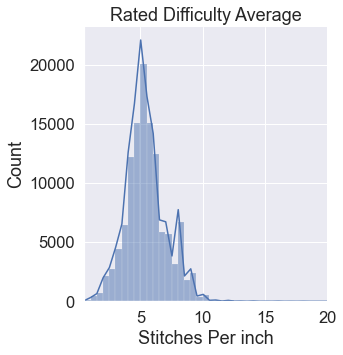

In [152]:
print(f'max gauge: {df.gauge_per_inch.max():.2f}')
print(f'median gauge: {df.gauge_per_inch.median():.2f}')
print(f'mean gauge: {df.gauge_per_inch.mean():.2f}')

p = sns.displot(x=df.gauge_per_inch , bins=200, kde=True).set(title='Rated Difficulty Average');
p.set( xlabel = "Stitches Per inch");

# will need to drop gague ? 15
plt.xlim(0.5, 20);

### Yarn Weights

Index(['pattern_id', 'name', 'name_permalink', 'favorites_count',
       'projects_count', 'difficulty_average', 'difficulty_count',
       'rating_average', 'queued_projects_count', 'rating_count',
       'pattern_type_names', 'pattern_type_clothing', 'photos_url',
       'pattern_needle_sizes', 'pattern_attributes', 'yardage_max', 'yardage',
       'generally_available', 'gauge', 'gauge_divisor', 'free', 'downloadable',
       'categories', 'yarn_weight_description', 'month_avail', 'year_avail',
       'needle_sizes', 'gauge_per_inch'],
      dtype='object')

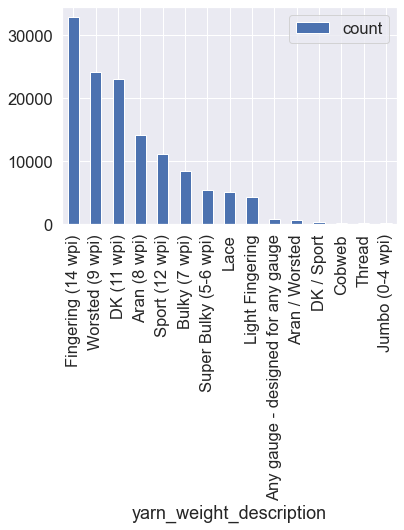

In [155]:
x = df[['yarn_weight_description', 'name']].groupby('yarn_weight_description', as_index = False).count().sort_values('name', ascending =False)
x.rename(columns={"name": "count"}, inplace=True)
ax = x.plot.bar(x='yarn_weight_description', y='count', rot=90)
# plt.xlim(4, 28);
df.columns

This lines up with the most popular projects being shawls and socks

In [158]:
df.columns

Index(['pattern_id', 'name', 'name_permalink', 'favorites_count',
       'projects_count', 'difficulty_average', 'difficulty_count',
       'rating_average', 'queued_projects_count', 'rating_count',
       'pattern_type_names', 'pattern_type_clothing', 'photos_url',
       'pattern_needle_sizes', 'pattern_attributes', 'yardage_max', 'yardage',
       'generally_available', 'gauge', 'gauge_divisor', 'free', 'downloadable',
       'categories', 'yarn_weight_description', 'month_avail', 'year_avail',
       'needle_sizes', 'gauge_per_inch'],
      dtype='object')

In [ ]:
correlation matrix (favourites, take first or last category) after fill 

In [ ]:
BOX PLOTS!

In [ ]:
# # Number of ratings per book
# data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# # Create trace
# trace = go.Histogram(x = data.values,
#                      name = 'Ratings',
#                      xbins = dict(start = 0,
#                                   end = 50,
#                                   size = 2))
# # Create layout
# layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 100)',
#                    xaxis = dict(title = 'Number of Ratings Per Book'),
#                    yaxis = dict(title = 'Count'),
#                    bargap = 0.2)

# # Create plot
# fig = go.Figure(data=[trace], layout=layout)
# iplot(fig)

In [ ]:
# # try this out (from https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b)

# from plotly.offline import init_notebook_mode, plot, iplot
# import plotly.graph_objs as go
# init_notebook_mode(connected=True)

# data = df['bookRating'].value_counts().sort_index(ascending=False)
# trace = go.Bar(x = data.index,
#                text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
#                textposition = 'auto',
#                textfont = dict(color = '#000000'),
#                y = data.values,
#                )
# # Create layout
# layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
#               xaxis = dict(title = 'Rating'),
#               yaxis = dict(title = 'Count'))
# # Create plot
# fig = go.Figure(data=[trace], layout=layout)
# iplot(fig)